In [1]:
from pathlib import Path
import json, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Paths ---
RUNS = Path("runs")
ART  = Path("artifacts"); (ART / "figs").mkdir(parents=True, exist_ok=True)

# --- Policy knobs (edit to taste) ---
SLO_P95_MS = 50.0        # Best-under-SLO for Tables
K_MAIN = 10              # Recall@10 as main accuracy metric
EMBEDDERS = None         # None -> infer from runs; or ['bge-base','e5-base','minilm']

# Preferred order if present
METHOD_ORDER = ["Flat", "LSH", "Annoy", "HNSW", "IVF-Flat", "IVF-PQ", "IVF-OPQ-PQ"]

# Matplotlib: one plot per figure, no explicit colors
plt.rcParams.update({"figure.dpi": 120, "savefig.bbox": "tight"})

def load_runs(run_root: Path) -> pd.DataFrame:
    rows = []
    if not run_root.exists():
        print(f"[warn] RUNS dir not found: {run_root.resolve()}")
        return pd.DataFrame(columns=[
            'model','variant','method','recall@10','recall@100','p50_ms','p95_ms','size_MB','build_s'
        ])
    for model_dir in run_root.iterdir():
        if not model_dir.is_dir():
            continue
        model = model_dir.name
        for variant_dir in model_dir.iterdir():
            mfile = variant_dir / "metrics.json"
            if not mfile.exists(): 
                continue
            try:
                with open(mfile, "r", encoding="utf-8") as f:
                    m = json.load(f)
            except Exception as e:
                print(f"[skip] Bad JSON: {mfile}: {e}")
                continue
            rows.append({
                "model": model,
                "variant": variant_dir.name,
                "method": m.get("method"),
                "recall@10": float(m.get("recall@10", 0.0) or 0.0),
                "recall@100": float(m.get("recall@100", 0.0) or 0.0),
                "p50_ms": float(m.get("latency_p50_ms", 0.0) or 0.0),
                "p95_ms": float(m.get("latency_p95_ms", 0.0) or 0.0),
                "size_MB": (float(m.get("index_size_bytes", 0) or 0)/1e6),
                "build_s": float(m.get("build_time_s", 0.0) or 0.0),
            })
    return pd.DataFrame(rows)

def parse_hparams(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    hp = {
        "LSH":      [("nbits", r"LSH_nb(\d+)")],
        "Annoy":    [("n_trees", r"Annoy_t(\d+)_"), ("search_k", r"sk(\d+)")],
        "HNSW":     [("M", r"HNSW_M(\d+)_"), ("efC", r"efC(\d+)_"), ("efSearch", r"efS(\d+)")],
        "IVF-Flat": [("nlist", r"nlist(\d+)"), ("nprobe", r"nprobe(\d+)")],
        "IVF-PQ":   [("nlist", r"nlist(\d+)"), ("m", r"_m(\d+)_"), ("nbits", r"_nb(\d+)_"), ("nprobe", r"nprobe(\d+)")],
        "IVF-OPQ-PQ": [("nlist", r"nlist(\d+)"), ("m", r"_m(\d+)_"), ("nbits", r"_nb(\d+)_"), ("nprobe", r"nprobe(\d+)")],
        "Flat": []
    }
    def extract(row):
        specs = []
        for name, pat in hp.get(row["method"], []):
            m = re.search(pat, row["variant"])
            if m:
                row[name] = int(m.group(1))
                specs.append(f"{name}={row[name]}")
        row["hparams"] = ", ".join(specs)
        return row
    if not df.empty:
        df = df.apply(extract, axis=1)
    return df

def best_under_slo(df: pd.DataFrame, slo_ms: float, embedders=None) -> pd.DataFrame:
    if embedders is None:
        embedders = sorted(df["model"].unique().tolist())
    best = []
    for model in embedders:
        for method in sorted(df["method"].unique()):
            sub = df[(df.model==model) & (df.method==method)]
            if sub.empty: 
                continue
            cand = sub[sub.p95_ms <= slo_ms]
            if cand.empty:
                cand = sub.copy()
            cand = cand.sort_values(by=["recall@10","p95_ms","size_MB"], ascending=[False, True, True])
            best.append(cand.iloc[0])
    return pd.DataFrame(best) if best else pd.DataFrame(columns=df.columns)

def pareto_front(points):
    # maximize recall@10, minimize p95 and size
    if not points:
        return np.array([], dtype=bool)
    arr = np.array(points, dtype=float)
    dom = np.zeros(len(arr), dtype=bool)
    for i in range(len(arr)):
        for j in range(len(arr)):
            if i == j: 
                continue
            if (arr[j,0] >= arr[i,0]) and (arr[j,1] <= arr[i,1]) and (arr[j,2] <= arr[i,2]) and \
               ((arr[j,0] > arr[i,0]) or (arr[j,1] < arr[i,1]) or (arr[j,2] < arr[i,2])):
                dom[i] = True
                break
    return ~dom

df = load_runs(RUNS)
if df.empty:
    raise SystemExit("No metrics found under runs/*/*/metrics.json — run your experiments first.")

df = parse_hparams(df)
if EMBEDDERS is None:
    EMBEDDERS = sorted(df['model'].unique().tolist())

display_cols = ["model","method","variant","hparams","recall@10","recall@100","p50_ms","p95_ms","size_MB"]
df[display_cols].sort_values(["model","method","variant"]).to_csv(ART/"runs_summary.csv", index=False)
print(f"[ok] Discovered {len(df)} runs; summary written to {ART/'runs_summary.csv'}")
df[display_cols].head(10)


[ok] Discovered 54 runs; summary written to artifacts/runs_summary.csv


,model,method,variant,hparams,recall@10,recall@100,p50_ms,p95_ms,size_MB
0,minilm,LSH,LSH_nb256,nbits=256,0.5077,0.46778,0.840902,1.098013,16.393309
1,minilm,LSH,LSH_nb64,nbits=64,0.1303,0.11352,0.435114,0.732017,4.098397
2,minilm,LSH,LSH_nb128,nbits=128,0.3169,0.26892,0.520229,0.685060,8.196701
3,minilm,IVF-Flat,IVFFlat_nlist707_nprobe8,"nlist=707, nprobe=8",0.8005,0.74095,0.144584,0.144584,773.091747
4,minilm,IVF-OPQ-PQ,IVF-OPQ-PQ_nlist707_m16_nb8_nprobe64,"nlist=707, m=16, nbits=8, nprobe=64",0.2831,0.30755,0.014695,0.014695,14.074899
5,minilm,Annoy,Annoy_t50_sk10000,"n_trees=50, search_k=10000",0.8321,0.76012,1.851439,2.118170,1095.268824
6,minilm,HNSW,HNSW_M16_efC200_efS64,"M=16, efC=200, efSearch=64",0.9744,0.92015,0.411749,0.529540,842.280136
7,minilm,Annoy,Annoy_t50_sk1000,"n_trees=50, search_k=1000",0.5258,0.40508,0.316024,0.418007,1095.268824
8,minilm,IVF-OPQ-PQ,IVF-OPQ-PQ_nlist707_m16_nb8_nprobe8,"nlist=707, m=16, nbits=8, nprobe=8",0.2807,0.30716,0.015694,0.015694,14.074899
9,minilm,Annoy,Annoy_t50_sk50000,"n_trees=50, search_k=50000",0.9496,0.91301,8.050561,11.078906,1095.268824


In [2]:
best = best_under_slo(df, SLO_P95_MS, embedders=EMBEDDERS)
if best.empty:
    raise SystemExit("No runs satisfy the SLO (or no runs found).")

agg = (best.groupby("method", as_index=False)
           .agg(recall10=("recall@10","mean"),
                recall100=("recall@100","mean"),
                p50=("p50_ms","mean"),
                p95=("p95_ms","mean"),
                size=("size_MB","mean")))

cat_methods = [m for m in METHOD_ORDER if m in agg["method"].tolist()]
agg["method"] = pd.Categorical(agg["method"], categories=cat_methods, ordered=True)
agg = agg.sort_values("method")

tex_path = ART/"table1_overall.tex"
with open(tex_path, "w") as f:
    f.write("\n".join([
        "\\begin{table*}[t]",
        "\\centering",
        f"\\caption{{Overall performance (mean across embedders) of best configuration per method under SLO $p95\\leq{SLO_P95_MS:.1f}$\\,ms.}}",
        "\\begin{tabular}{lccccc}\\toprule",
        "Method & Recall@10 & Recall@100 & p50 (ms) & p95 (ms) & Index size (MB)\\\\\\midrule",
    ]))
    for _,r in agg.iterrows():
        f.write(f"{r['method']} & {r['recall10']:.3f} & {r['recall100']:.3f} & {r['p50']:.1f} & {r['p95']:.1f} & {r['size']:.1f}\\\\\n")
    f.write("\\bottomrule\\end{tabular}\\end{table*}\n")

print(f"[ok] Wrote {tex_path}")
agg.round({"recall10":3,"recall100":3,"p50":1,"p95":1,"size":1})


[ok] Wrote artifacts/table1_overall.tex


,method,recall10,recall100,p50,p95,size
5,LSH,0.292,0.272,1.0,1.2,16.7
0,Annoy,0.943,0.914,9.3,12.6,1615.1
1,HNSW,0.982,0.962,1.2,2.0,1354.3
2,IVF-Flat,0.958,0.940,1.3,1.3,1285.8
4,IVF-PQ,0.347,0.393,0.2,0.2,19.8
3,IVF-OPQ-PQ,0.320,0.337,0.0,0.0,21.6


In [9]:
# Build LaTeX for the per-embedder best-config table with Recall@100 and p50
best = best_under_slo(df, SLO_P95_MS, embedders=EMBEDDERS)

# Order methods consistently
best["method"] = pd.Categorical(
    best["method"],
    categories=[m for m in METHOD_ORDER if m in best["method"].tolist()],
    ordered=True
)
best = best.sort_values(["model", "method"])

# Simple LaTeX escaper for underscores, percent, etc.
def latex_escape(s: str) -> str:
    if not isinstance(s, str):
        s = str(s)
    return (
        s.replace("\\", r"\textbackslash{}")
         .replace("_", r"\_")
         .replace("%", r"\%")
         .replace("&", r"\&")
         .replace("#", r"\#")
         .replace("{", r"\{")
         .replace("}", r"\}")
    )

# Columns to display
cols = ["model", "method", "hparams", "recall@10", "recall@100", "p50_ms", "p95_ms", "size_MB"]
missing = [c for c in cols if c not in best.columns]
if missing:
    raise KeyError(f"Missing columns in 'best': {missing}")

tex_path = ART / "table_best_per_embedder.tex"
with open(tex_path, "w", encoding="utf-8") as f:
    f.write("\n".join([
        r"\begin{table*}[t]",
        r"\centering",
        rf"\caption{{Best configuration per embedder and method under the latency constraint $p95 \leq {SLO_P95_MS:.1f}\,\mathrm{{ms}}$.}}",
        r"\label{tab:best-per-embedder}",
        r"\begin{tabular}{lllccccc}\toprule",
        r"Embedder & Method & Hyper-parameters & Recall@10 & Recall@100 & p50 (ms) & p95 (ms) & Size (MB)\\\midrule"
    ]))
    for _, r in best.iterrows():
        model = latex_escape(r["model"])
        method = latex_escape(r["method"])
        hparams = latex_escape(r.get("hparams", ""))
        f.write(
            f"{model} & {method} & {hparams} & "
            f"{r['recall@10']:.3f} & {r['recall@100']:.3f} & "
            f"{r['p50_ms']:.1f} & {r['p95_ms']:.1f} & {r['size_MB']:.1f}\\\\\n"
        )
    f.write(r"\bottomrule\end{tabular}\end{table*}" + "\n")

print(f"[ok] Wrote {tex_path}")


[ok] Wrote artifacts/table_best_per_embedder.tex


In [4]:
rows = []
for method in sorted(df["method"].unique()):
    sub = df[df.method==method]
    if sub.empty: 
        continue
    pts = list(zip(sub["recall@10"], sub["p95_ms"], sub["size_MB"]))
    mask = pareto_front(pts)
    rows.append({"method": method, "pareto_configs": int(np.sum(mask))})
t3 = pd.DataFrame(rows)

tex_path = ART/"table3_pareto.tex"
with open(tex_path, "w") as f:
    f.write("\n".join([
        "\\begin{table}[t]",
        "\\centering",
        "\\caption{Pareto-optimal configurations per method over \\{Recall@10 $\\uparrow$, p95 $\\downarrow$, size $\\downarrow$\\}.}",
        "\\begin{tabular}{lc}\\toprule Method & Pareto configs\\\\\\midrule",
    ]))
    for _,r in t3.iterrows():
        f.write(f"{r['method']} & {int(r['pareto_configs'])}\\\\\n")
    f.write("\\bottomrule\\end{tabular}\\end{table}\n")
print(f"[ok] Wrote {tex_path}")
t3


[ok] Wrote artifacts/table3_pareto.tex


,method,pareto_configs
0,Annoy,6
1,HNSW,3
2,IVF-Flat,6
3,IVF-OPQ-PQ,3
4,IVF-PQ,6
5,LSH,5


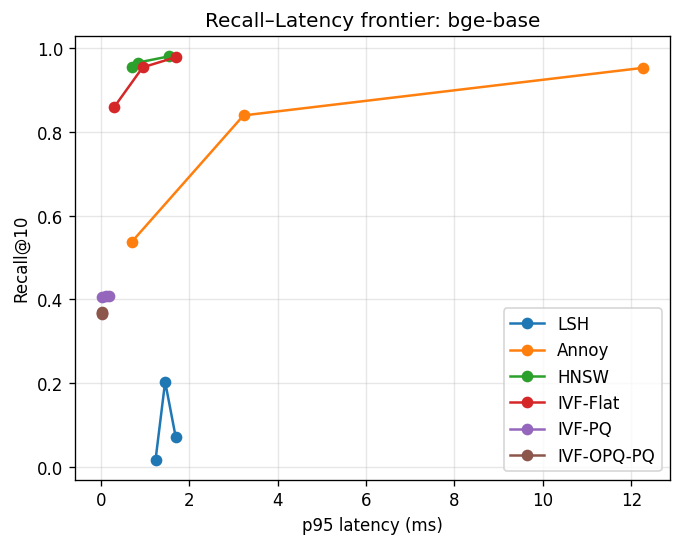

[ok] Wrote artifacts/figs/recall_latency_bge-base.pdf


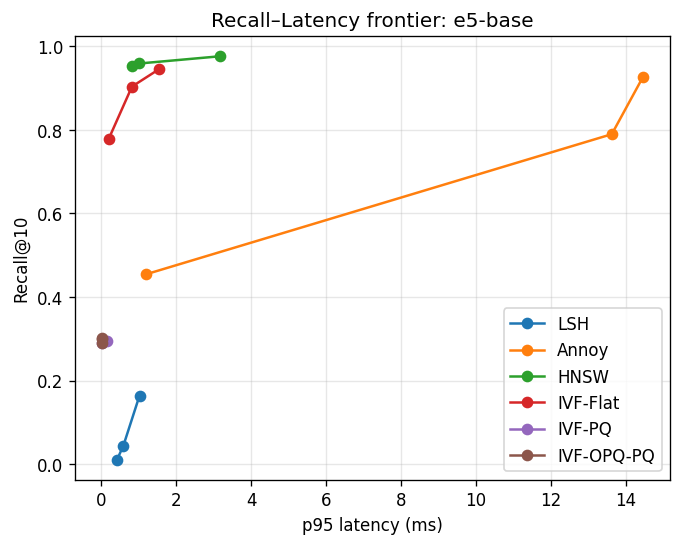

[ok] Wrote artifacts/figs/recall_latency_e5-base.pdf


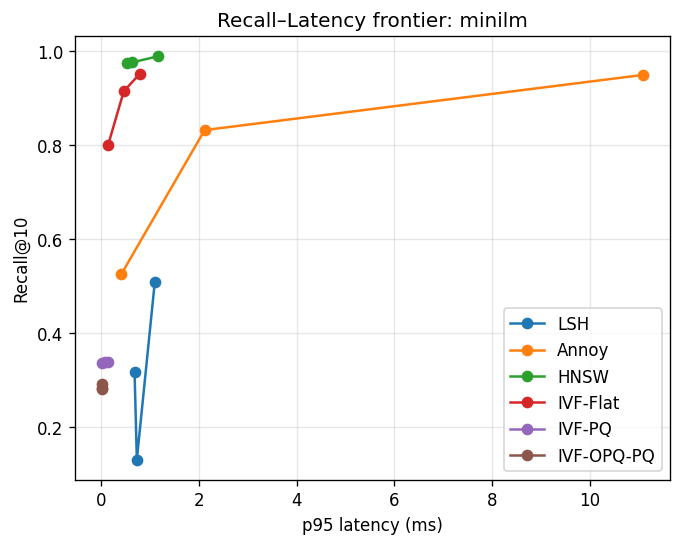

[ok] Wrote artifacts/figs/recall_latency_minilm.pdf


In [5]:
for model in EMBEDDERS:
    sub = df[df.model==model].copy()
    if sub.empty: 
        continue
    methods_present = [m for m in METHOD_ORDER if m in sub['method'].unique()]
    plt.figure()
    for m in methods_present:
        ss = sub[sub.method==m].copy()
        if ss.empty: continue
        ss = ss.sort_values("p95_ms")
        plt.plot(ss["p95_ms"], ss["recall@10"], marker="o", label=m)
    plt.xlabel("p95 latency (ms)")
    plt.ylabel("Recall@10")
    plt.title(f"Recall–Latency frontier: {model}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    out = ART / "figs" / f"recall_latency_{model}.pdf"
    plt.savefig(out); plt.show()
    print(f"[ok] Wrote {out}")


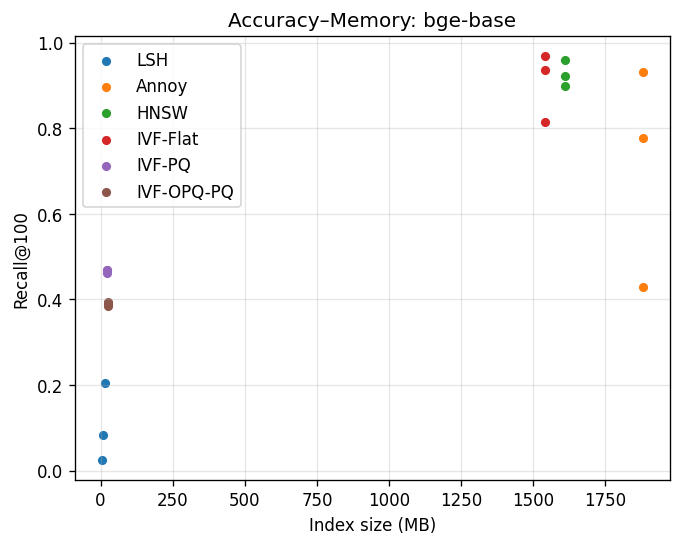

[ok] Wrote artifacts/figs/acc_memory_bge-base.pdf


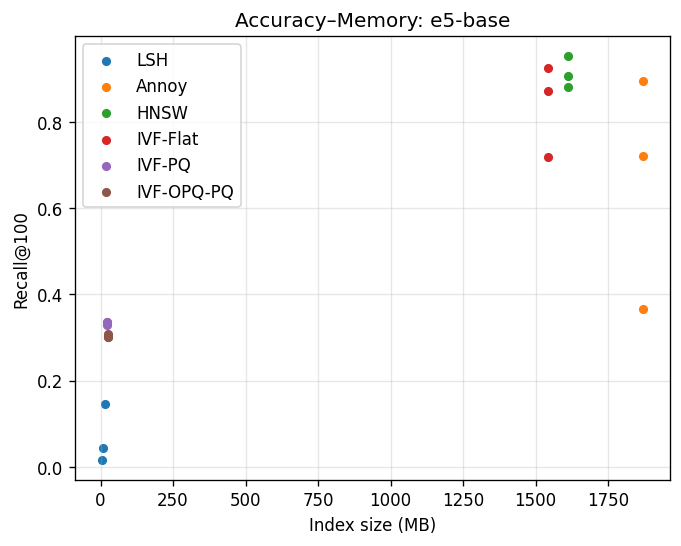

[ok] Wrote artifacts/figs/acc_memory_e5-base.pdf


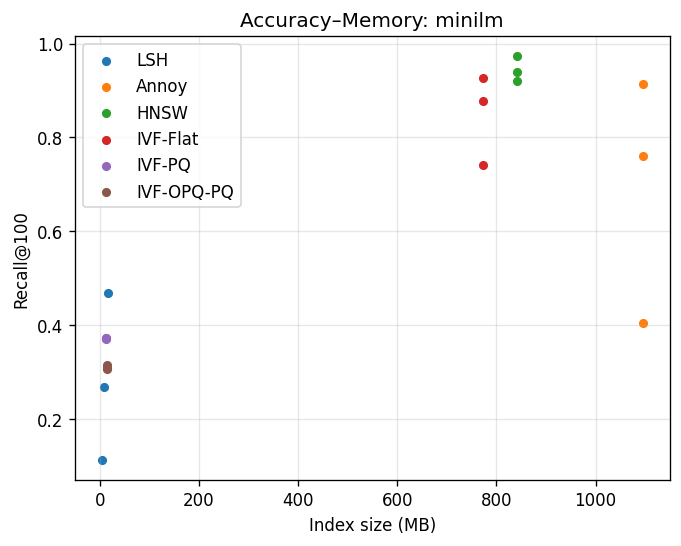

[ok] Wrote artifacts/figs/acc_memory_minilm.pdf


In [6]:
for model in EMBEDDERS:
    sub = df[df.model==model].copy()
    if sub.empty: 
        continue
    methods_present = [m for m in METHOD_ORDER if m in sub['method'].unique()]
    plt.figure()
    for m in methods_present:
        ss = sub[sub.method==m]
        if ss.empty: continue
        plt.scatter(ss["size_MB"], ss["recall@100"], label=m, s=20)
    plt.xlabel("Index size (MB)")
    plt.ylabel("Recall@100")
    plt.title(f"Accuracy–Memory: {model}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    out = ART / "figs" / f"acc_memory_{model}.pdf"
    plt.savefig(out); plt.show()
    print(f"[ok] Wrote {out}")


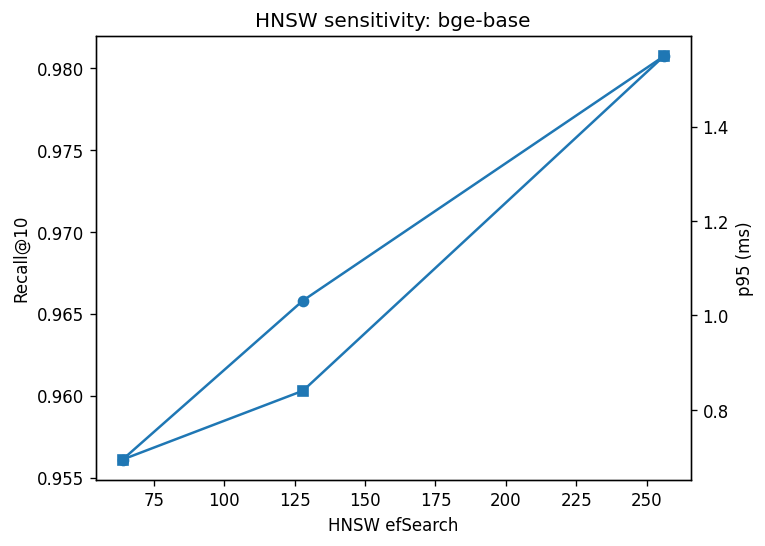

[ok] Wrote artifacts/figs/hnsw_sweep_bge-base.pdf


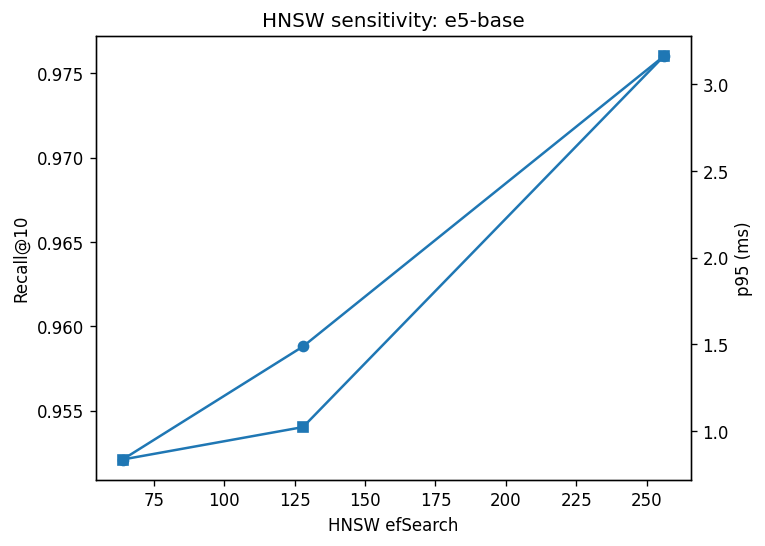

[ok] Wrote artifacts/figs/hnsw_sweep_e5-base.pdf


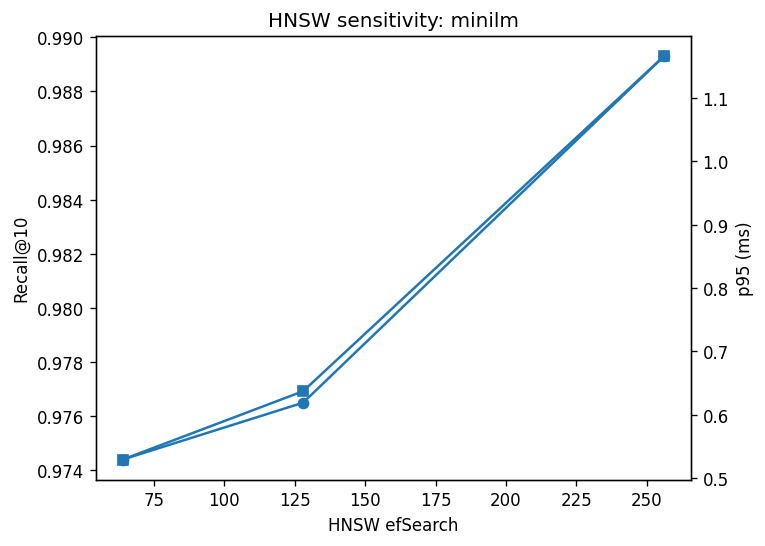

[ok] Wrote artifacts/figs/hnsw_sweep_minilm.pdf


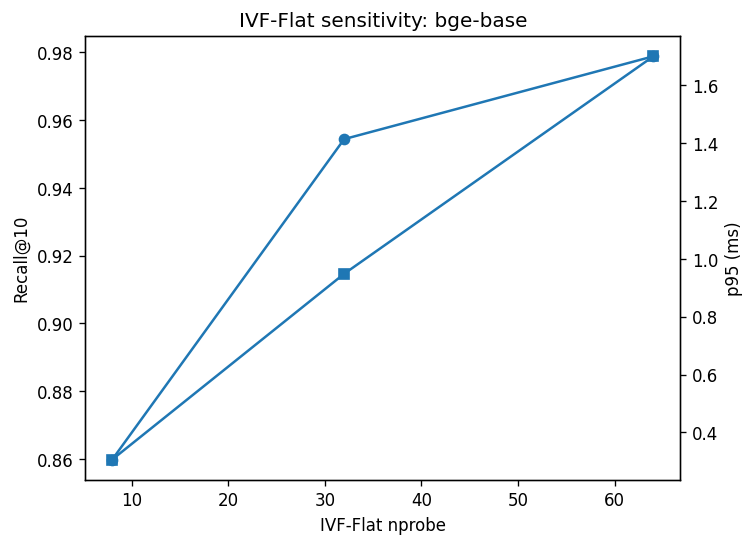

[ok] Wrote artifacts/figs/ivfflat_sweep_bge-base.pdf


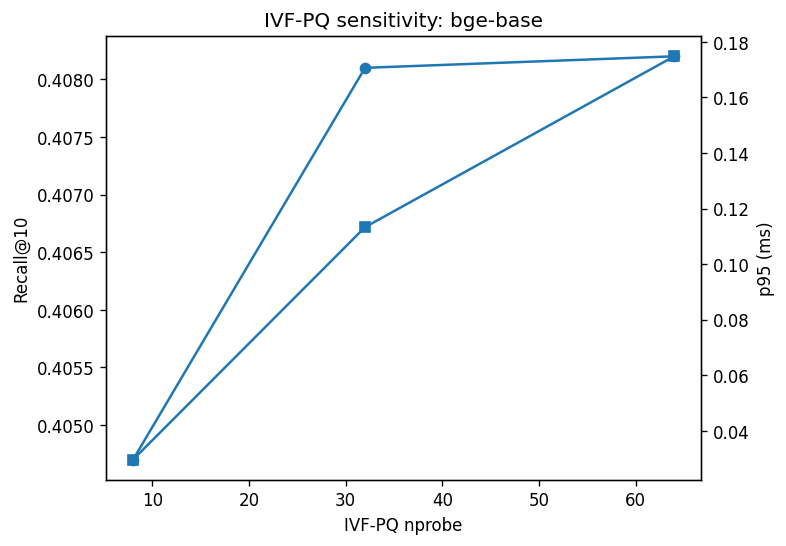

[ok] Wrote artifacts/figs/ivfpq_sweep_bge-base.pdf


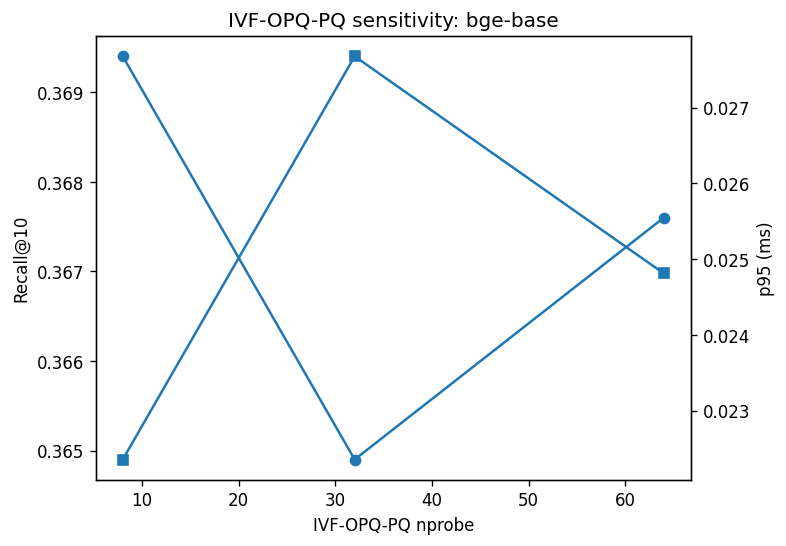

[ok] Wrote artifacts/figs/ivfopqpq_sweep_bge-base.pdf


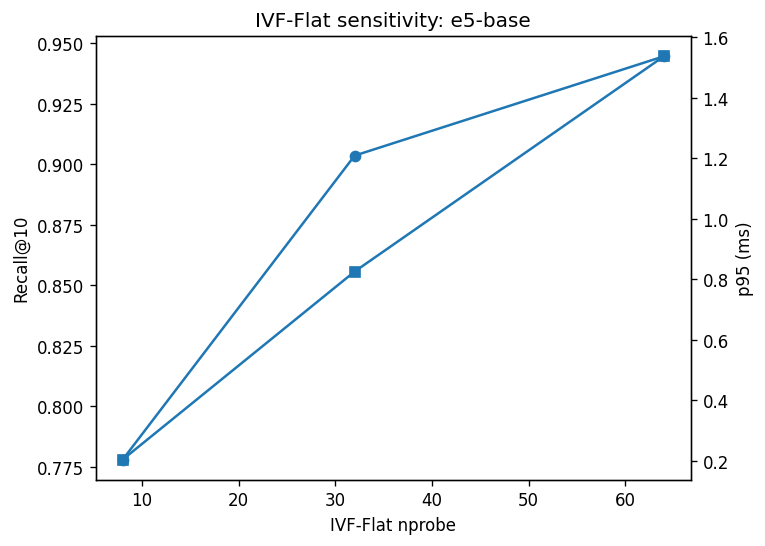

[ok] Wrote artifacts/figs/ivfflat_sweep_e5-base.pdf


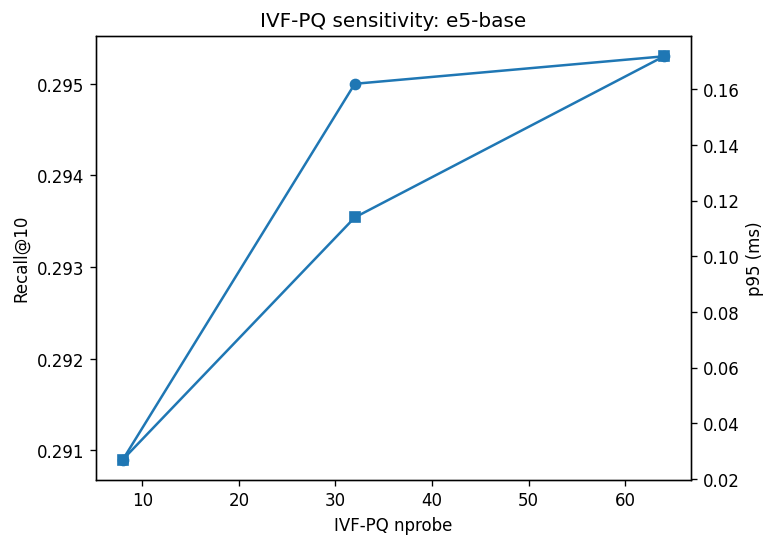

[ok] Wrote artifacts/figs/ivfpq_sweep_e5-base.pdf


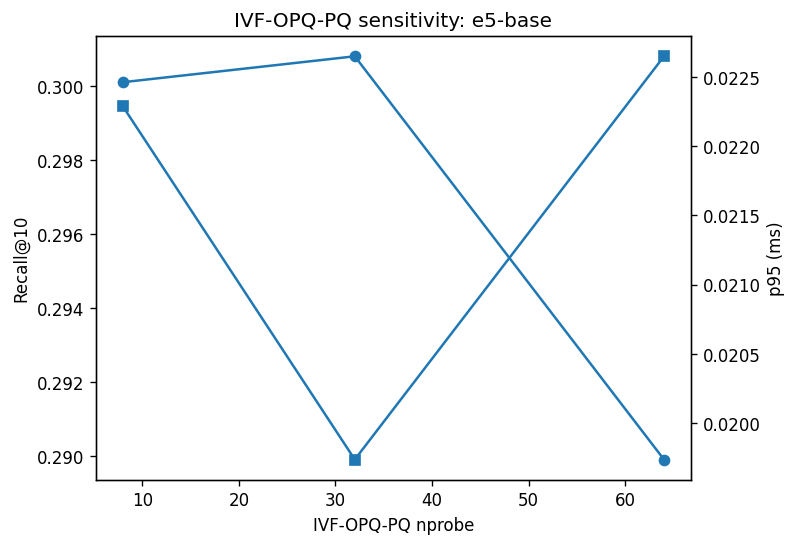

[ok] Wrote artifacts/figs/ivfopqpq_sweep_e5-base.pdf


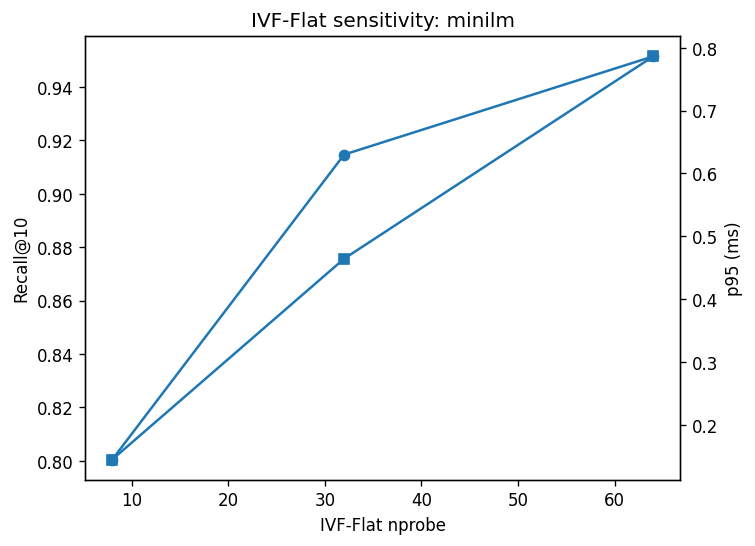

[ok] Wrote artifacts/figs/ivfflat_sweep_minilm.pdf


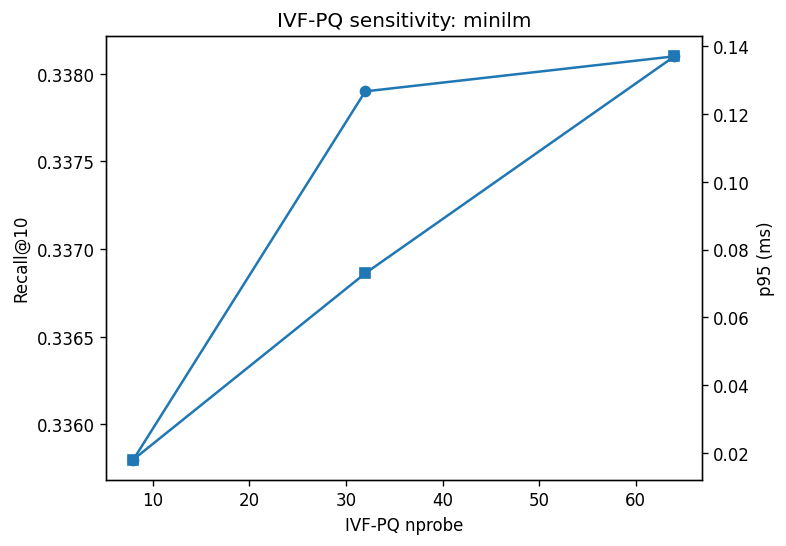

[ok] Wrote artifacts/figs/ivfpq_sweep_minilm.pdf


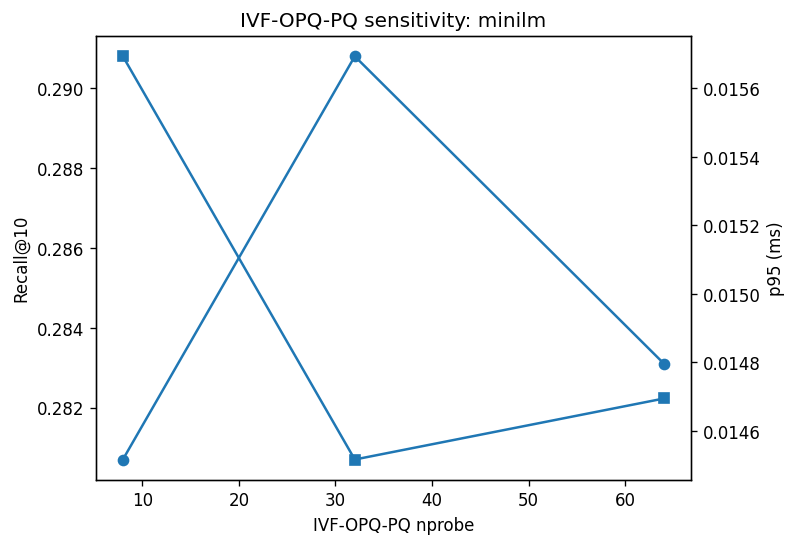

[ok] Wrote artifacts/figs/ivfopqpq_sweep_minilm.pdf


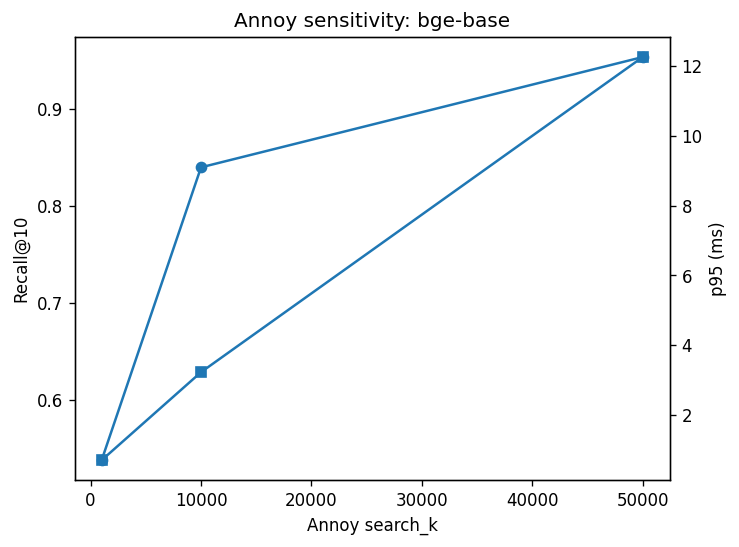

[ok] Wrote artifacts/figs/annoy_sweep_bge-base.pdf


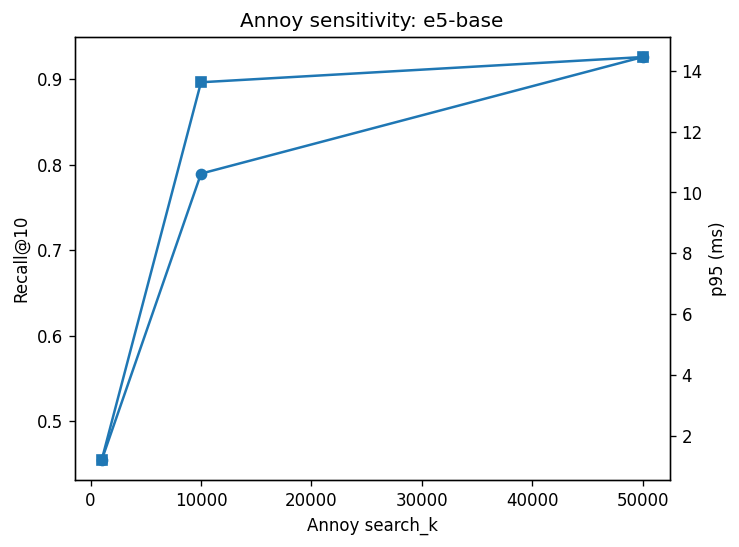

[ok] Wrote artifacts/figs/annoy_sweep_e5-base.pdf


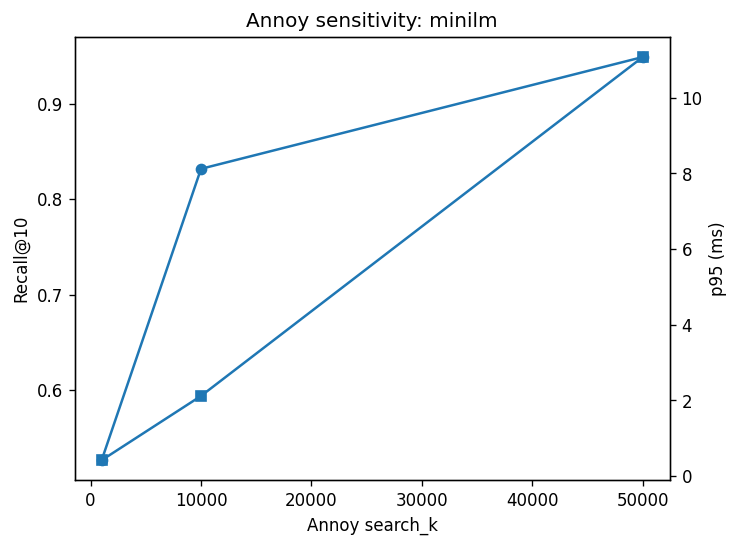

[ok] Wrote artifacts/figs/annoy_sweep_minilm.pdf


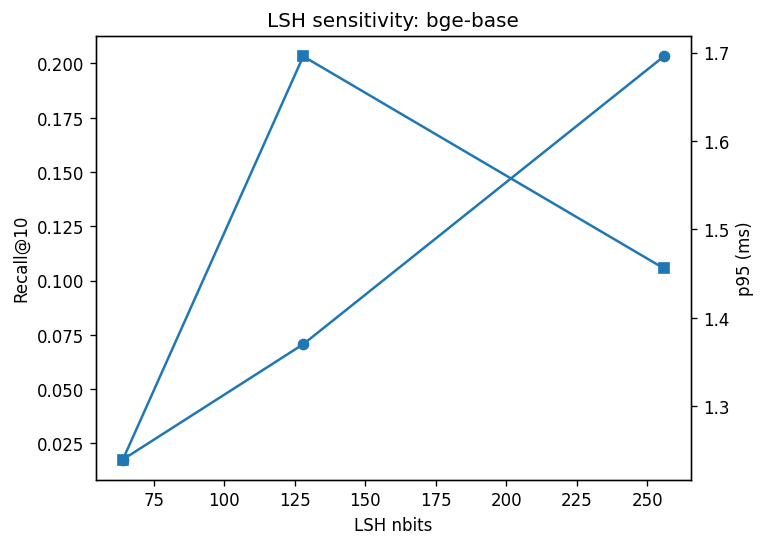

[ok] Wrote artifacts/figs/lsh_sweep_bge-base.pdf


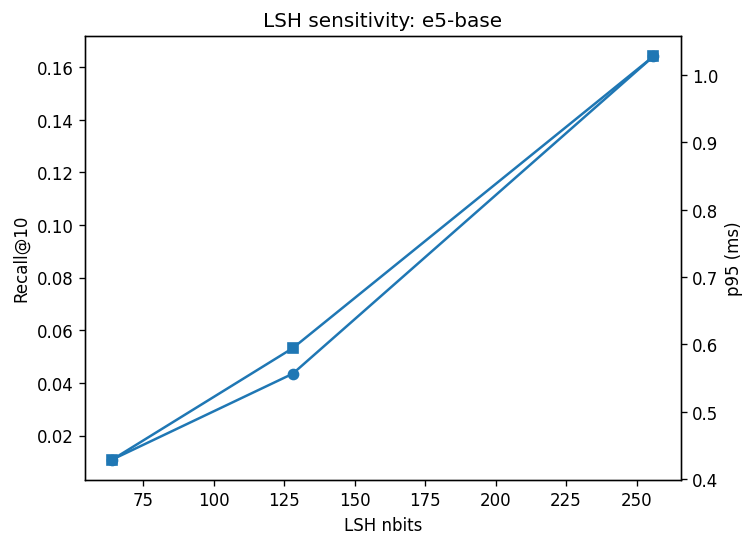

[ok] Wrote artifacts/figs/lsh_sweep_e5-base.pdf


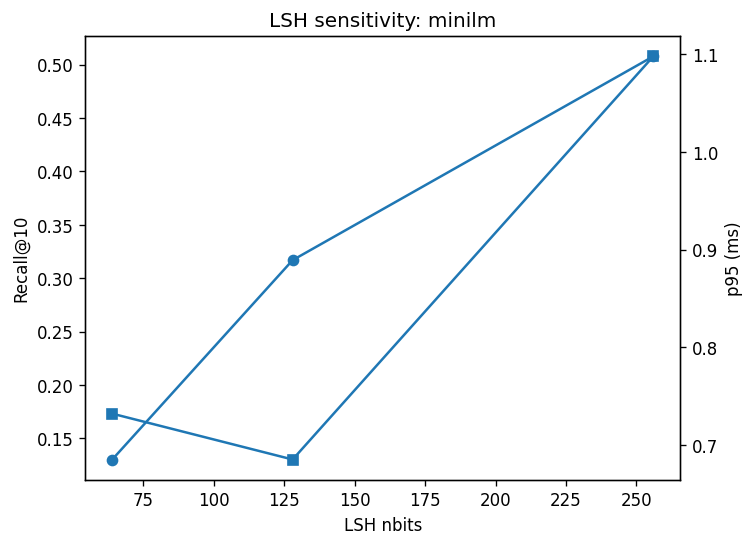

[ok] Wrote artifacts/figs/lsh_sweep_minilm.pdf


In [7]:
# HNSW: efSearch
for model in EMBEDDERS:
    sub = df[(df.model==model) & (df.method=="HNSW")].copy()
    if sub.empty or "efSearch" not in sub.columns:
        continue
    ss = sub.sort_values("efSearch")
    fig = plt.figure()
    ax1 = plt.gca()
    ax1.plot(ss["efSearch"], ss["recall@10"], marker="o")
    ax1.set_xlabel("HNSW efSearch")
    ax1.set_ylabel("Recall@10")
    ax2 = ax1.twinx()
    ax2.plot(ss["efSearch"], ss["p95_ms"], marker="s")
    ax2.set_ylabel("p95 (ms)")
    plt.title(f"HNSW sensitivity: {model}")
    out = ART / "figs" / f"hnsw_sweep_{model}.pdf"
    plt.savefig(out); plt.show()
    print(f"[ok] Wrote {out}")

# IVF nprobe
for model in EMBEDDERS:
    for meth in ["IVF-Flat","IVF-PQ","IVF-OPQ-PQ"]:
        sub = df[(df.model==model) & (df.method==meth)].copy()
        if sub.empty or "nprobe" not in sub.columns:
            continue
        ss = sub.sort_values("nprobe")
        fig = plt.figure()
        ax1 = plt.gca()
        ax1.plot(ss["nprobe"], ss["recall@10"], marker="o")
        ax1.set_xlabel(f"{meth} nprobe")
        ax1.set_ylabel("Recall@10")
        ax2 = ax1.twinx()
        ax2.plot(ss["nprobe"], ss["p95_ms"], marker="s")
        ax2.set_ylabel("p95 (ms)")
        plt.title(f"{meth} sensitivity: {model}")
        out = ART / "figs" / f"{meth.replace('-','').lower()}_sweep_{model}.pdf"
        plt.savefig(out); plt.show()
        print(f"[ok] Wrote {out}")

# Annoy search_k
for model in EMBEDDERS:
    sub = df[(df.model==model) & (df.method=="Annoy")].copy()
    if sub.empty or "search_k" not in sub.columns:
        continue
    ss = sub.sort_values("search_k")
    fig = plt.figure()
    ax1 = plt.gca()
    ax1.plot(ss["search_k"], ss["recall@10"], marker="o")
    ax1.set_xlabel("Annoy search_k")
    ax1.set_ylabel("Recall@10")
    ax2 = ax1.twinx()
    ax2.plot(ss["search_k"], ss["p95_ms"], marker="s")
    ax2.set_ylabel("p95 (ms)")
    plt.title(f"Annoy sensitivity: {model}")
    out = ART / "figs" / f"annoy_sweep_{model}.pdf"
    plt.savefig(out); plt.show()
    print(f"[ok] Wrote {out}")

# LSH nbits
for model in EMBEDDERS:
    sub = df[(df.model==model) & (df.method=="LSH")].copy()
    if sub.empty or "nbits" not in sub.columns:
        continue
    ss = sub.sort_values("nbits")
    fig = plt.figure()
    ax1 = plt.gca()
    ax1.plot(ss["nbits"], ss["recall@10"], marker="o")
    ax1.set_xlabel("LSH nbits")
    ax1.set_ylabel("Recall@10")
    ax2 = ax1.twinx()
    ax2.plot(ss["nbits"], ss["p95_ms"], marker="s")
    ax2.set_ylabel("p95 (ms)")
    plt.title(f"LSH sensitivity: {model}")
    out = ART / "figs" / f"lsh_sweep_{model}.pdf"
    plt.savefig(out); plt.show()
    print(f"[ok] Wrote {out}")


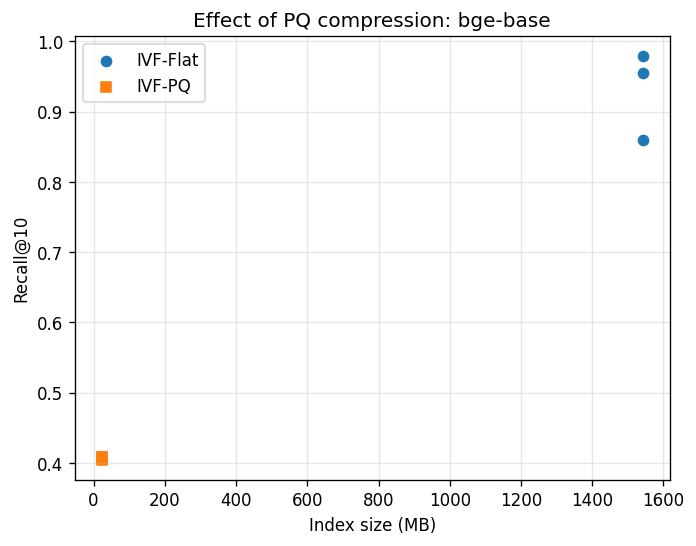

[ok] Wrote artifacts/figs/ivf_pq_vs_flat_bge-base.pdf


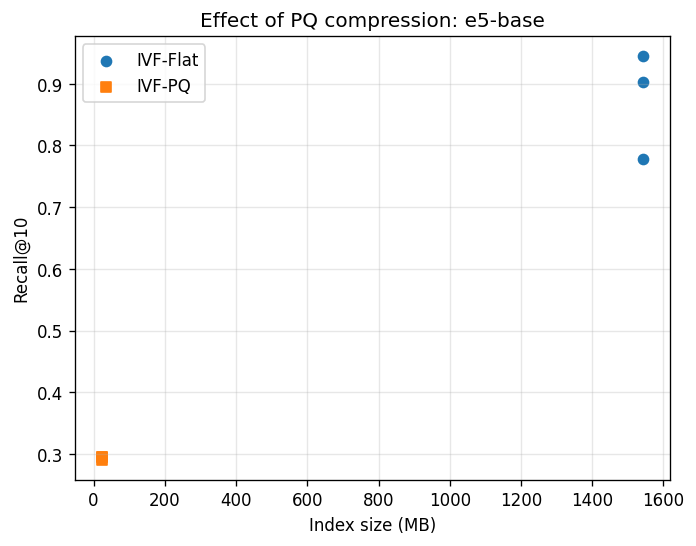

[ok] Wrote artifacts/figs/ivf_pq_vs_flat_e5-base.pdf


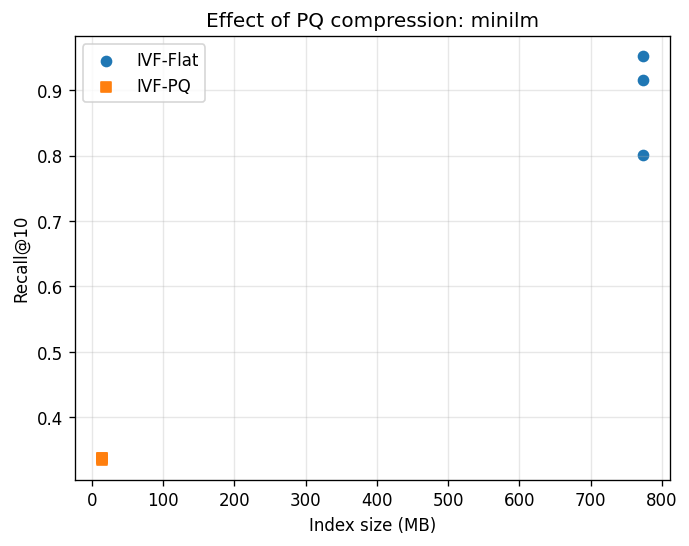

[ok] Wrote artifacts/figs/ivf_pq_vs_flat_minilm.pdf


In [8]:
for model in EMBEDDERS:
    sub_flat = df[(df.model==model) & (df.method=="IVF-Flat")]
    sub_pq   = df[(df.model==model) & (df.method=="IVF-PQ")]
    if sub_flat.empty or sub_pq.empty:
        continue
    plt.figure()
    plt.scatter(sub_flat["size_MB"], sub_flat["recall@10"], label="IVF-Flat")
    plt.scatter(sub_pq["size_MB"],   sub_pq["recall@10"],   label="IVF-PQ", marker="s")
    plt.xlabel("Index size (MB)")
    plt.ylabel("Recall@10")
    plt.title(f"Effect of PQ compression: {model}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    out = ART / "figs" / f"ivf_pq_vs_flat_{model}.pdf"
    plt.savefig(out); plt.show()
    print(f"[ok] Wrote {out}")
